## CITE-Seq analysis
(adapted from [Processing and integrating 5k PBMCs CITE-seq data by Danila Bredikhin](https://muon-tutorials.readthedocs.io/en/latest/cite-seq/1-CITE-seq-PBMC-5k.html))

- Data availability: [Atlas of Human Breast Cancers](https://singlecell.broadinstitute.org/single_cell/study/SCP1039/a-single-cell-and-spatially-resolved-atlas-of-human-breast-cancers#/)

In [2]:

import os
import numpy as np
import pandas as pd
import scanpy as sc
import scipy.io
import muon as mu
from muon import prot as pt
import polars as pl

In [135]:
# Path to CITE-seq data
data_dir = "data/SCP1039"
cite_data_path = "data/SCP1039/other/CITE/3946_CITE.miniatlas/read_count"

try:
    # muon reads in cite seq data
    cite_data = mu.read_10x_mtx(cite_data_path)
    print("Successfully loaded CITE-seq data with muon")
    print(f"Data shape: {cite_data.shape}")
    
except Exception as e:
    print(f"Error loading with muon: {e}")
    print(f"Manual Read...")
    
    mtx_path = os.path.join(cite_data_path, "matrix.mtx.gz")
    barcodes_path = os.path.join(cite_data_path,"barcodes.tsv.gz")
    features_path = os.path.join(cite_data_path, "features.tsv.gz")
    
    matrix = scipy.io.mmread(mtx_path).T.tocsr() 
    barcodes = pd.read_csv(barcodes_path, header=None, sep='\t')[0].values
    features = pd.read_csv(features_path, header=None, sep='\t')
    
    # Create anndata object
    import anndata as ad
    cite_data = ad.AnnData(X=matrix, obs=pd.DataFrame(index=barcodes), var=pd.DataFrame(index=features[0].values))
    
    # merge features
    if features.shape[1] > 1:
        cite_data.var['feature_names'] = features[0].values
        cite_data.var['feature_types'] = 'Antibody Capture'
    
    print("Successfully loaded CITE-seq data manually")
    print(f"Data shape: {cite_data.shape}")
    
print(f"Feature types: {cite_data.var['feature_types'].unique() if 'feature_types' in cite_data.var.columns else 'Not specified'}")

Error loading with muon: 1
Manual Read...
Successfully loaded CITE-seq data manually
Data shape: (722, 118)
Feature types: Not specified


In [136]:
import polars as pl

rna_data_path = "data/SCP1039/expression"

try:
    # muon reads in sc rna seq data
    rna_data = mu.read_10x_mtx(rna_data_path)
    
except Exception as e:
    print(f"Error loading RNA with muon: {e}")

# partition out dataframes for rnaseq data
df = pl.DataFrame({
    'full_barcode': rna_data.obs_names,
    'patient_id': [patient.split('_')[0] for patient in rna_data.obs_names],
    'cell_barcode': [patient.split('_')[1] for patient in rna_data.obs_names]
})

patient_counts = df.group_by('patient_id').count()
print("Counts per patient:")
print(patient_counts)
print(patient_counts.filter(pl.col('patient_id') == 'CID3946'))

prot_bc = set(barcodes)
rna_bc = set(pl.Series(df.select('cell_barcode')).to_list())
common_bc = rna_barcodes.intersection(prot_bc)

print(f"Protein BC: {len(prot_bc)}\n"
      f"RNA BC: {len(rna_bc)}\n"
      f"Common BC: {len(common_bc)}\n")

KeyboardInterrupt: 

Index(['CD3-CTCATTGTAACTCCT', 'CD4-TGTTCCCGCTCAACT', 'CD8a-GCTGCGCTTTCCATT',
       'CD14-TCTCAGACCTCCGTA', 'CD15-TTGGACGTGCGATCT', 'CD16-AAGTTCACTCTTTGC',
       'CD19-CTGGGCAATTACTCG', 'CD25-TTTGTCCTGTACGCC', 'CD28-ATTCTGTCTTTCCCA',
       'CD40-CTCAGATGGAGTATG',
       ...
       'CD115-AATCACGGTCCTTGT', 'TLR4-GCTTAGCTGTATCCG',
       'CD49a-ACTGATGGACTCAGA', 'CD73-CAGTTCCTCAGTTCG',
       'TCR_V24-J18-AACTTCTGTGGTAGC', 'CD49d-CCATTCAACTTCCGG',
       'CD49f-TTCCGAGGATGATCT', 'TCRVa7_2-TACGAGCAGTATTCA',
       'FCER1A-CTCGTTTCCGTATCG', 'unmapped'],
      dtype='object', length=118)


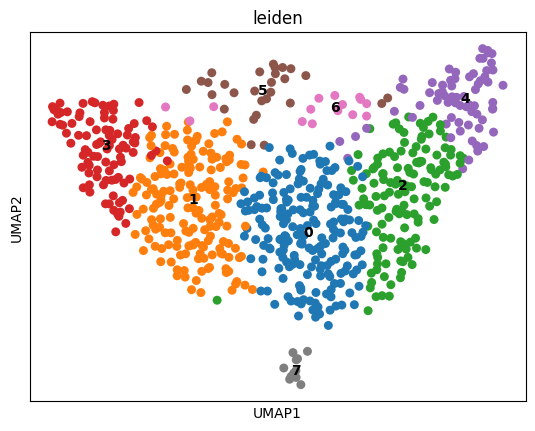

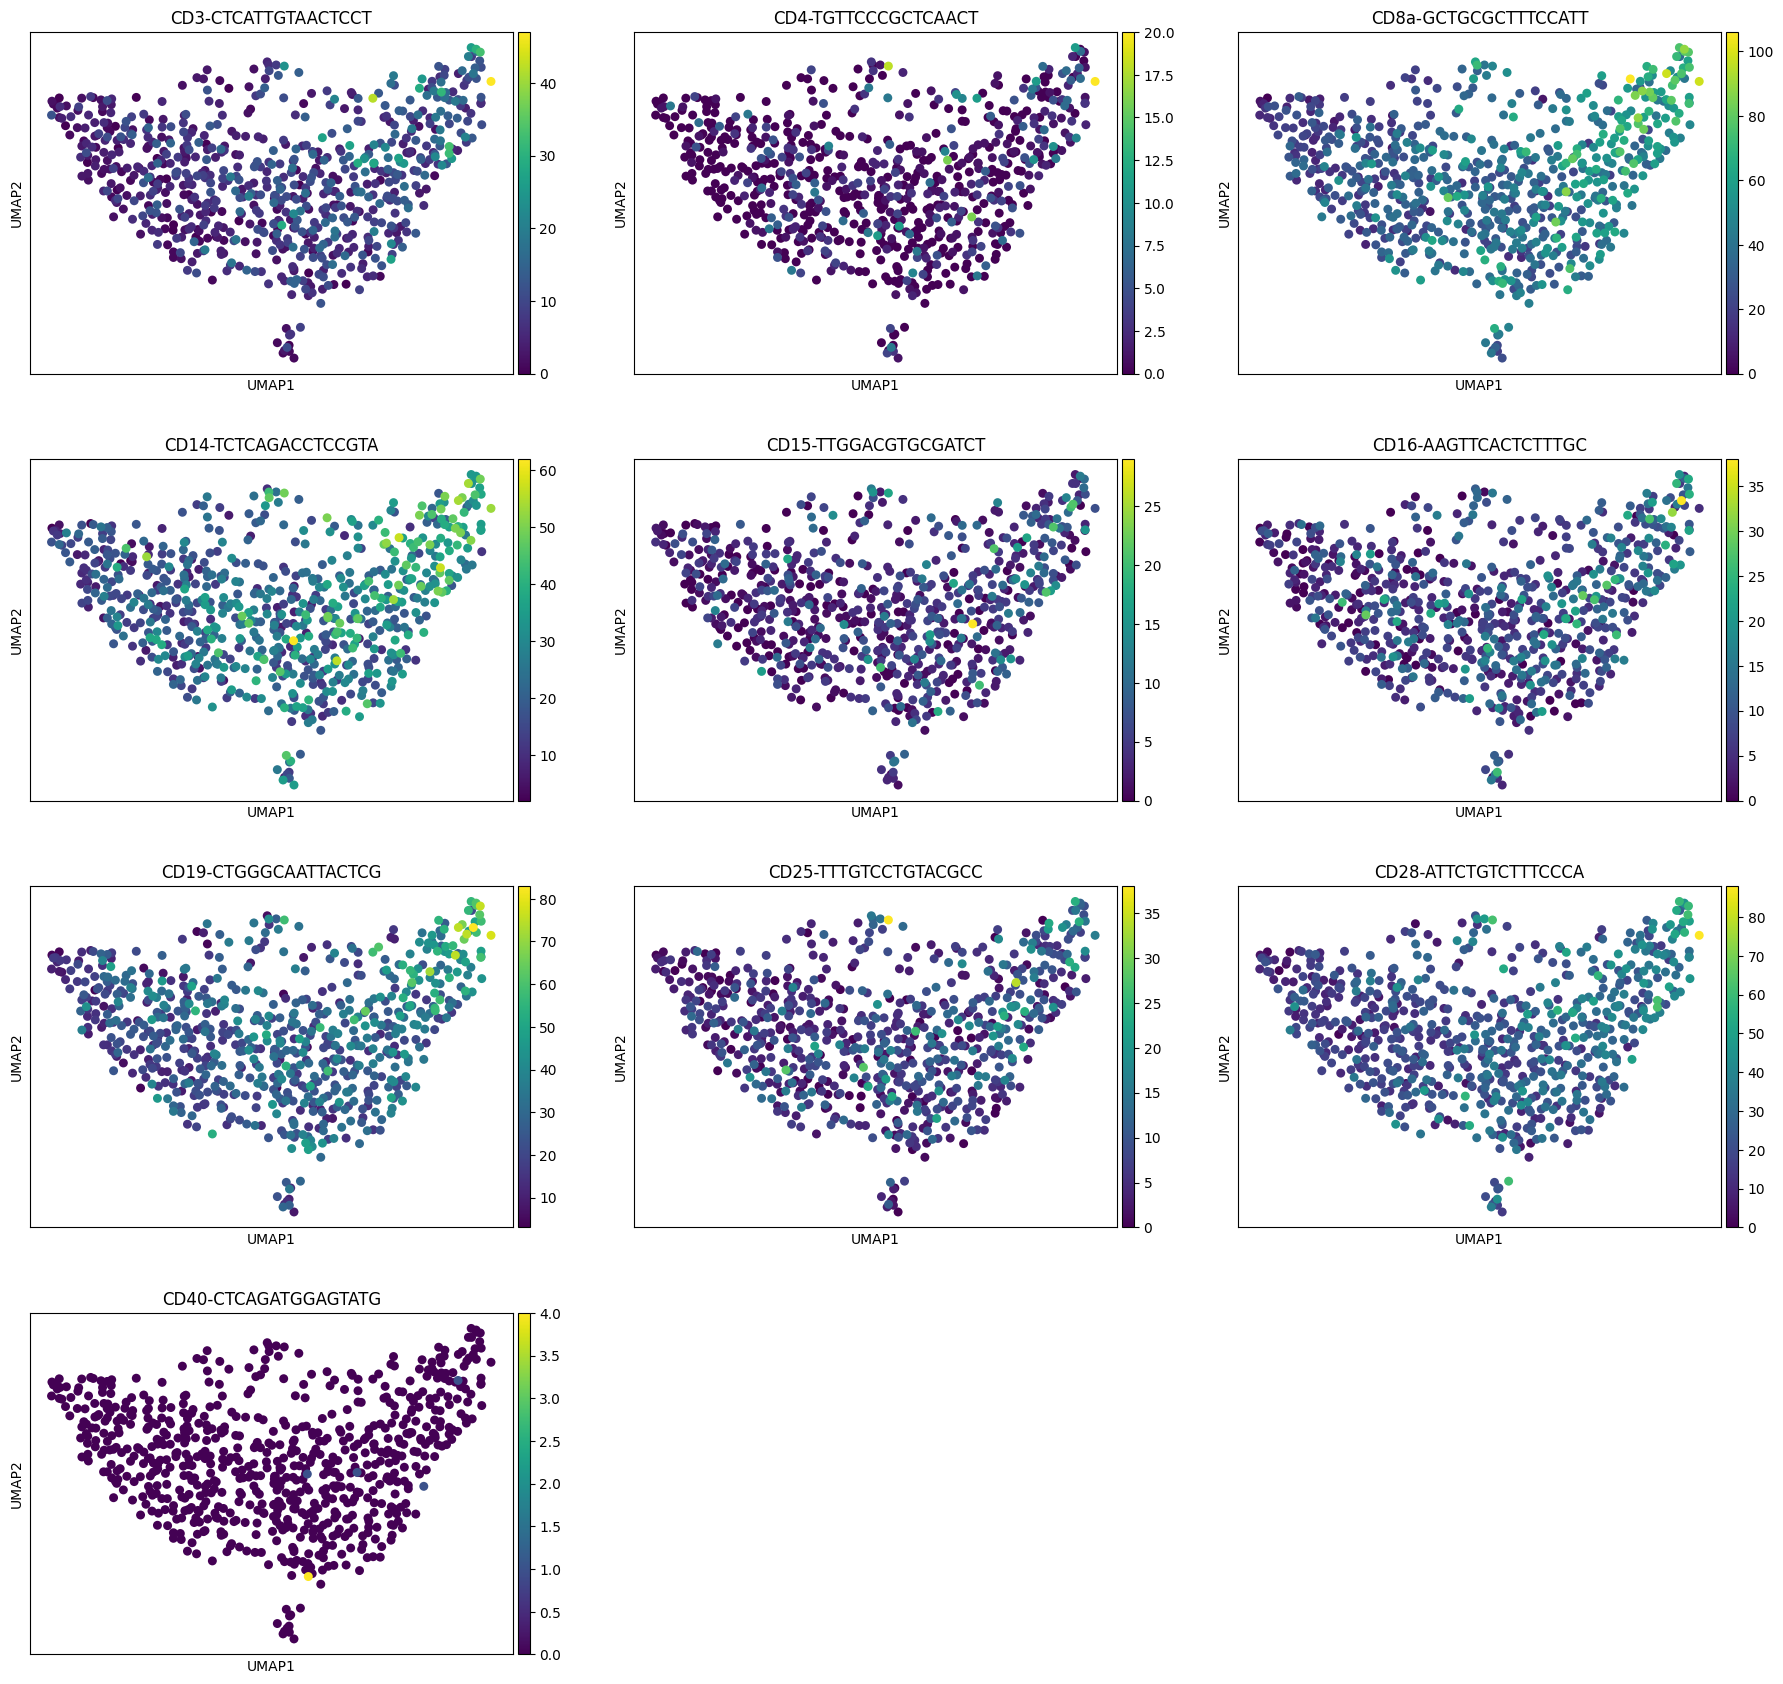

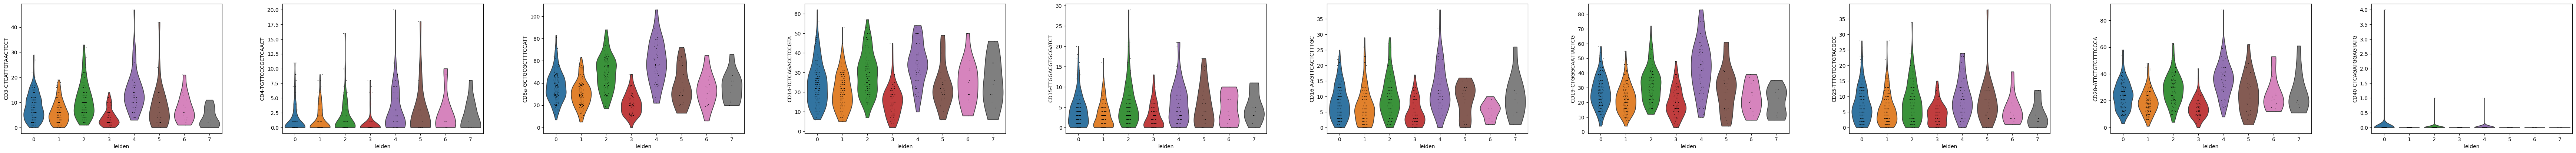

In [123]:
protein_data = cite_data
sc.tl.pca(protein_data)
sc.pp.neighbors(protein_data)
sc.tl.umap(protein_data)
sc.tl.leiden(protein_data, resolution=0.9)

sc.pl.umap(protein_data, color=['leiden'], legend_loc='on data')
proteins_of_interest = protein_data.var_names[:10]  
sc.pl.umap(protein_data, color=proteins_of_interest, ncols=3)
sc.pl.violin(protein_data, proteins_of_interest, groupby='leiden')

/Users/nwlodychak/miniconda3/envs/cite_seq/lib/python3.11/site-packages/scanpy/preprocessing/_normalization.py:235: UserWarning: Some cells have zero counts
  warn(UserWarning("Some cells have zero counts"))
/Users/nwlodychak/miniconda3/envs/cite_seq/lib/python3.11/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/nwlodychak/miniconda3/envs/cite_seq/lib/python3.11/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


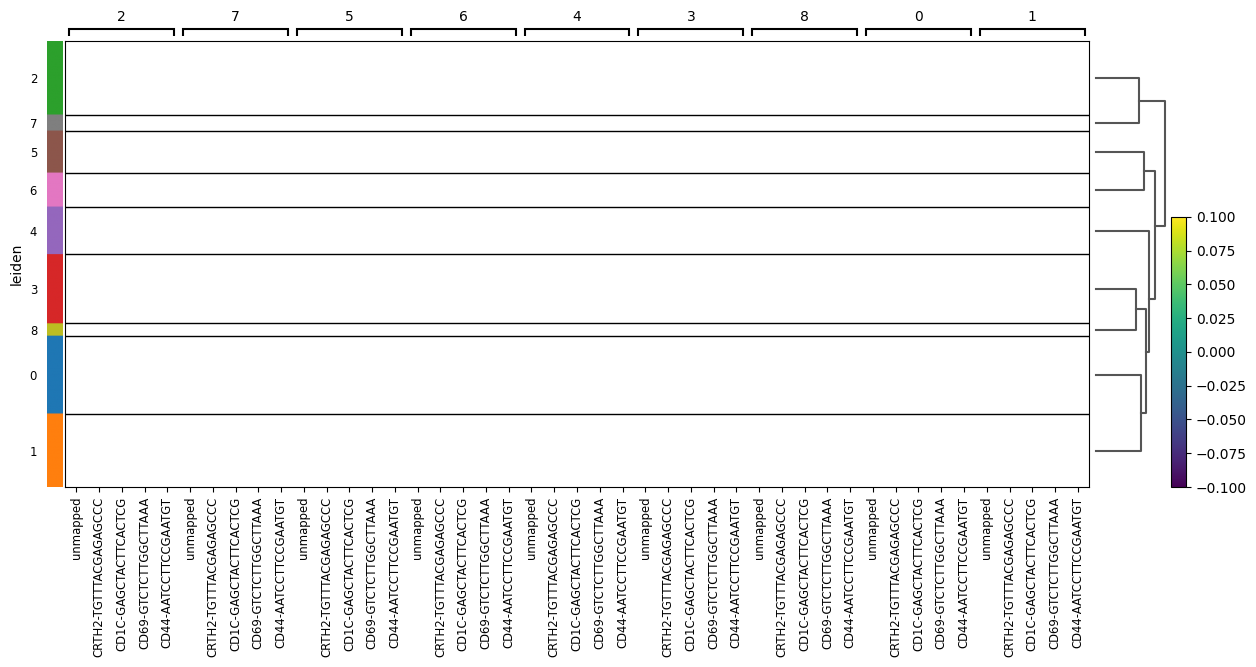

/Users/nwlodychak/miniconda3/envs/cite_seq/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


ValueError: The condensed distance matrix must contain only finite values.

<Figure size 1200x1000 with 0 Axes>

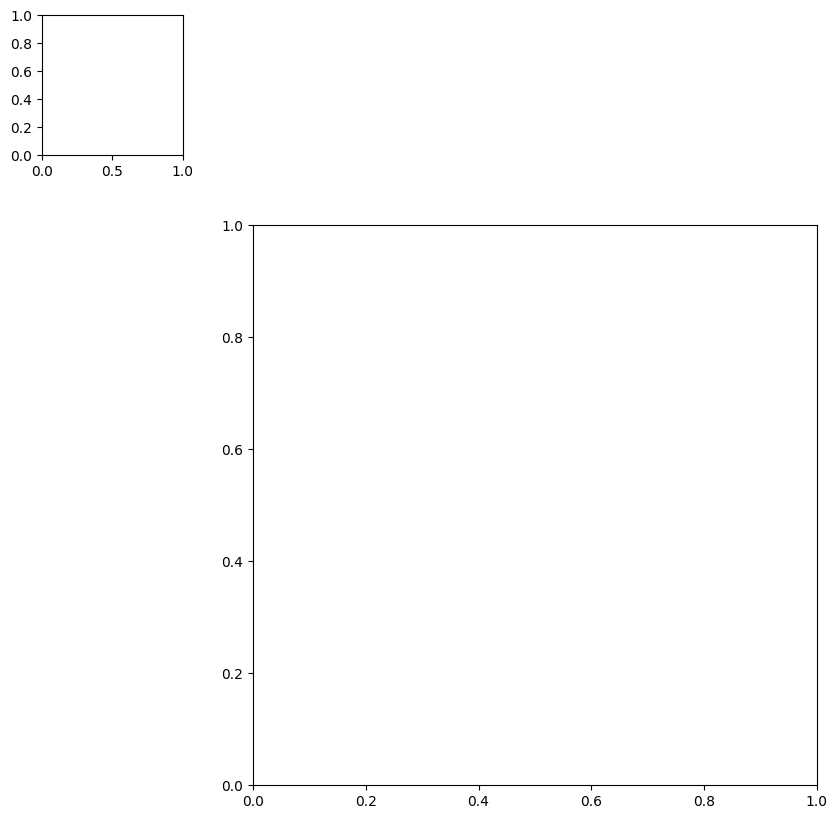

In [134]:
import seaborn as sns
import matplotlib.pyplot as plt
# Rank gene clusters
cite_data = protein_data
sc.pp.normalize_total(cite_data)
sc.pp.log1p(cite_data)
sc.pp.scale(cite_data)

sc.tl.rank_genes_groups(cite_data, 'leiden', method='wilcoxon')

# Heatmap 1
sc.pl.rank_genes_groups_heatmap(cite_data, n_genes=5, groupby='leiden')

# Heatmap 2
plt.figure(figsize=(12, 10))
sns.clustermap(cite_data.X, 
               row_cluster=True, 
               col_cluster=True,
               standard_scale=0,  # Scale the rows
               cmap='viridis')
plt.savefig('protein_expression_heatmap.png')

# Differentially expressed genes
markers = sc.get.rank_genes_groups_df(cite_data, group='0', reference='1')
markers.head()